### In this file, the spiral model is tested with a dataset different from the one the model was trained on.

In [1]:
%load_ext autoreload
%autoreload 2

### imports:

In [32]:
# PyTorch imports:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

# Model imports:
from model_spiral import Model

# OpenCV imports:
import cv2

# NumPy imports:
import numpy as np

# Utils imports:
from utils.utils import plot_images

# Datasetset imports:
from data.dataset import *

# Matplotlib imports:
import matplotlib.pyplot as plt

# Other imports:
import os
import json

In [3]:
# This allows the matplotlib library to plot without any errors
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Getting the device

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Loading the model:

In [5]:
# Creating an instance of the model:
image_dim = (128, 128)
model = Model(image_dim=image_dim)

In [6]:
# Getting the model's path
MODEL_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'model_spiral_v3')

In [7]:
# Loading the model:
model.load_state_dict(torch.load(MODEL_PATH))

# Setting the model to evaluation mode:
model.eval()

Model(
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (module_list): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=256, out_features=2, bias

# Loading the data:

### Pre-processing criteria:

In [8]:
transform = T.Compose([
    T.ToTensor(),
    T.Grayscale(num_output_channels=1),
    T.Resize(image_dim)
])

### Getting the path of the dataset:

In [9]:
# Getting the dataset path:

# Getting the path of the json file that contains all the paths:
DATA_JSON_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', 'data_path.txt')

# Loading the json and selecting the path of the desired dataset:
with open(DATA_JSON_PATH, 'r') as file:
    dataset_path = json.loads(file.read())['demo_spiral']

### Creating the dataset:

In [10]:
dataset = ParkinsonDataset(type='spiral', path=dataset_path, transform=transform)

### Creating the DataLoader from the dataset:

In [11]:
batch_size, num_workers = 1, 2
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

# Visualizing a random sample of the images in the dataset:

In [30]:
# Generating random indecies to sample from the dataset:
indecies = np.random.choice(np.arange(len(dataset)), 16, replace=False)

# Creating two arrays that hold the sampled images and their labels:
images = [dataset[i][0] for i in indecies]
labels = [dataset.rev_mapping[dataset[i][1]] for i in indecies]

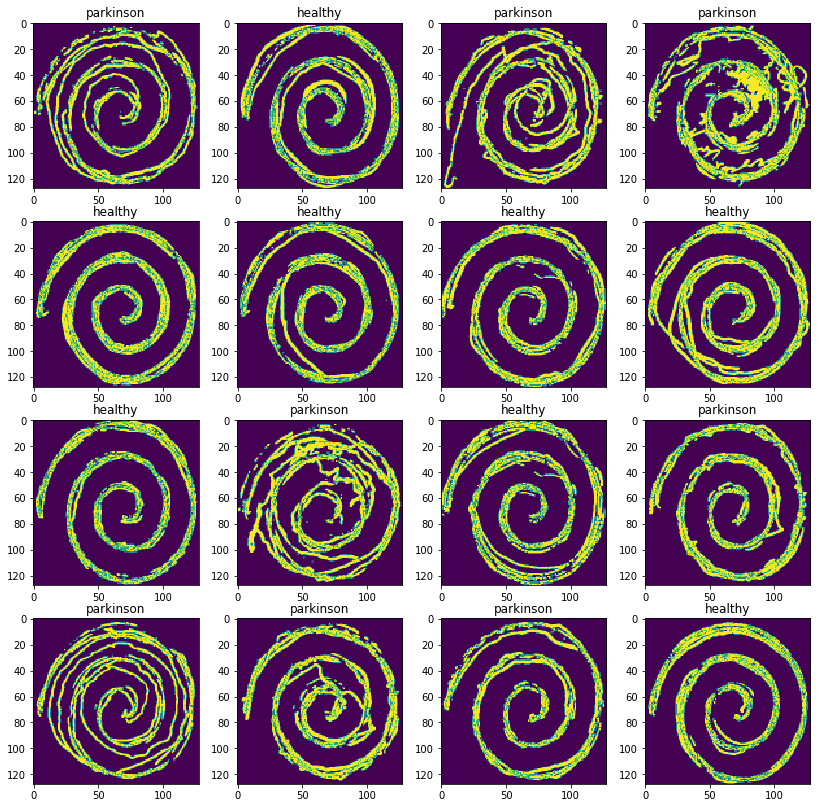

In [33]:
# Creating the subplots:
fig, axarr = plt.subplots(4, 4)

# Defining the figure size:
fig_size = 14

# Setting the figure size:
fig.set_figwidth(fig_size)
fig.set_figheight(fig_size)

# Iterating over the images, labels, and subplots
for image, label, ax in zip(images, labels, axarr.flatten()):
    # Converting the image from torch.Tensor to numpy array and squeezing it:
    image = image.cpu().detach().numpy().squeeze()
    # Setting the title to be the label:
    ax.set_title(label)
    # Plotting the image:
    ax.imshow(image)

# Generate predictions:

In [35]:
preds = []

for x, y in data_loader:
    # Moving the images and labels to the selected device:
    x = x.to(device)
    y = y.to(device)
    
    # Moving the model to the selected device:
    model = model.to(device)
    
    # Genearte the prediction:
    y_pred = model(x)
    
    # Applying argmax:
    _, y_pred = torch.max(y_pred, axis=1)
    
    # Getting the text prediction:
    y_pred = dataset.rev_mapping[y_pred.item()]
    
    # Appending the prediction to the predictions array:
    preds.append(y_pred)

In [53]:
accuracy = 100 * np.sum(np.array(preds)==np.array([dataset.rev_mapping[label] for label in dataset.labels])) / len(dataset)

# Visualising a sample from the dataset with true labels and predictions:

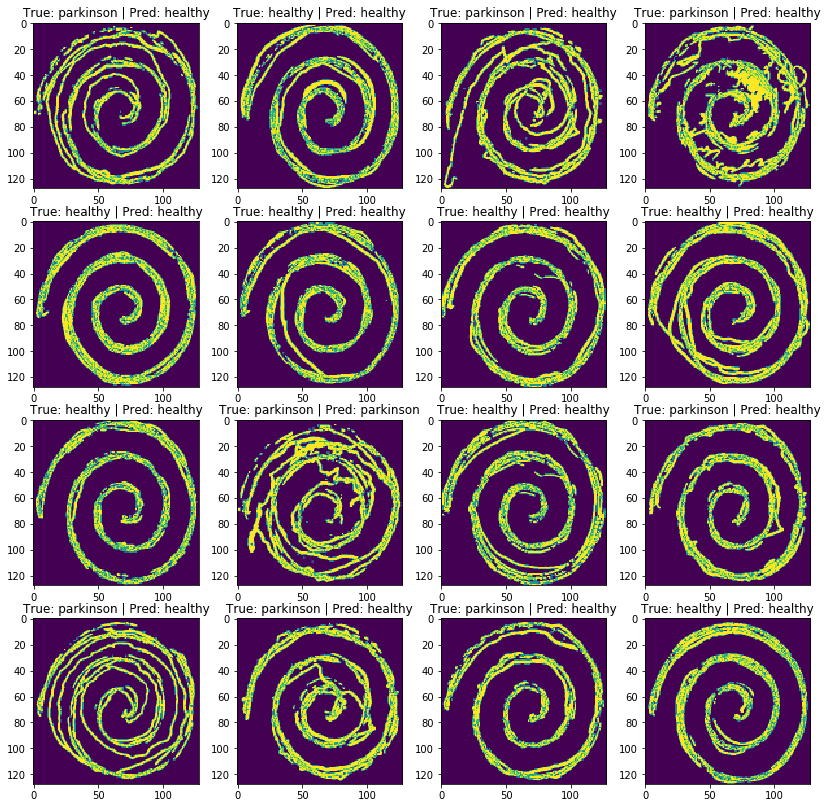

In [56]:
fig, axarr = plt.subplots(4, 4)

fig_size = 14

fig.set_figwidth(fig_size)
fig.set_figheight(fig_size)

sample_preds = np.array(preds)[indecies]

for image, label, pred, ax in zip(images, labels, sample_preds, axarr.flatten()):
    image = image.cpu().detach().numpy().squeeze()
    
    ax.set_title(f'True: {label} | Pred: {pred}')
    ax.imshow(image)